# Link Prediction

In [11]:
import networkx as nx
import random
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import torch
import numpy as np
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE, GAE
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

## 1. Data analysis

In [12]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")

In [13]:
print("number of nodes: ", len(g.nodes))
print("number of edges: ", len(g.edges))

number of nodes:  3363
number of edges:  13547


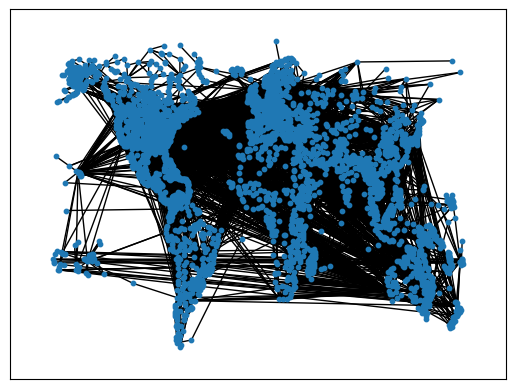

In [14]:
pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
nx.draw_networkx(g, pos=pos, node_size=10, with_labels=False)

With Gephi we have optain this graph:
![](./gephi_analyse/airports_coord_pop_graph.svg)

In [15]:
#Example of the a node
g.nodes()['0']

{'lon': -145.50972222222222,
 'lat': -17.35388888888889,
 'population': 10000,
 'country': 'FRENCH_POLYNESIA',
 'city_name': 'Anaa'}

In [16]:
g.graph = {}
data1 = from_networkx(g, group_node_attrs=["lon", "lat"])
data2 = from_networkx(g, group_node_attrs=["lon", "lat", "population"])
data1: Data = train_test_split_edges(data1, test_ratio=0.1)
data2: Data = train_test_split_edges(data2, test_ratio=0.1)
print(data1)
print(data2)

/home/valentin/.local/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 2], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])
Data(country=[3363], city_name=[3363], x=[3363, 3], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])


- x=[3363, 2] => pour chaque noeud, les coordonnées lat et lon
- val_pos_edge_index=[2, 677] => 2 ligne, la première c'est d'où on pars, la deuxième c'est où on va
- test_pos_edge_index=[2, 1354] => /
- train_pos_edge_index=[2, 23032] => /
- train_neg_adj_mask=[3363, 3363] => matrice d'adjacence, vrai si pas de lien, faux sinon
- val_neg_edge_index=[2, 677] => /
- test_neg_edge_index=[2, 1354] => /


## Modeles definitions and tested

### GAE with GAE Encoder

In [20]:
class GAEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [21]:
def trainGAE(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(model, data, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [9]:
model = GAE(GAEncoder(data1.num_features, 2))
optim = torch.optim.Adam(model.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
for epoch in range(500):
    better = False
    loss = trainGAE(model, optim, data1)

    auc, ap = test(model, data1, data1.val_pos_edge_index, data1.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bmodel = model
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print("##FINAL TEST##")
auc, ap = test(bmodel, data1, data1.test_pos_edge_index, data1.test_neg_edge_index)
print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))


    Epoch: 000, AUC: 0.5694, AP: 0.5374
    Epoch: 001, AUC: 0.5764, AP: 0.5414
    Epoch: 002, AUC: 0.5890, AP: 0.5490
    Epoch: 003, AUC: 0.5981, AP: 0.5546
    Epoch: 004, AUC: 0.6203, AP: 0.5688
    Epoch: 005, AUC: 0.6570, AP: 0.5940
    Epoch: 006, AUC: 0.6903, AP: 0.6191
    Epoch: 007, AUC: 0.7152, AP: 0.6393
    Epoch: 008, AUC: 0.7194, AP: 0.6430
    Epoch: 009, AUC: 0.7234, AP: 0.6468
Epoch: 010, AUC: 0.7185, AP: 0.6432
Epoch: 011, AUC: 0.7193, AP: 0.6439
Epoch: 012, AUC: 0.7220, AP: 0.6462
    Epoch: 013, AUC: 0.7254, AP: 0.6491
    Epoch: 014, AUC: 0.7273, AP: 0.6506
    Epoch: 015, AUC: 0.7274, AP: 0.6505
Epoch: 016, AUC: 0.7274, AP: 0.6503
    Epoch: 017, AUC: 0.7278, AP: 0.6506
Epoch: 018, AUC: 0.7264, AP: 0.6493
Epoch: 019, AUC: 0.7263, AP: 0.6493
Epoch: 020, AUC: 0.7267, AP: 0.6496
Epoch: 021, AUC: 0.7268, AP: 0.6497
Epoch: 022, AUC: 0.7254, AP: 0.6484
Epoch: 023, AUC: 0.7243, AP: 0.6474
Epoch: 024, AUC: 0.7233, AP: 0.6467
Epoch: 025, AUC: 0.7229, AP: 0.6463
Epoch: 0

#### Visualise the map with the result of decoder

number of nodes: 3363
number of edges: 25086


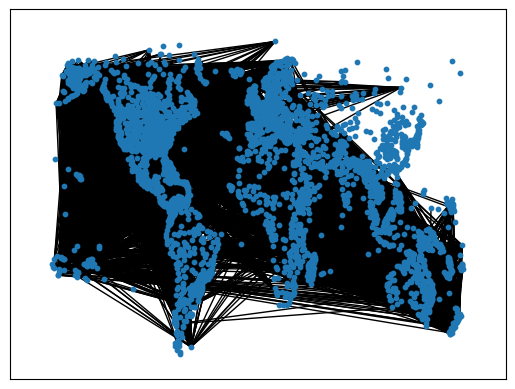

In [10]:
def visualise_output_prediction(bmodel, data, g):
    z = bmodel.encode(data.x, data.train_pos_edge_index)
    Ahat = torch.sigmoid(z @ z.T)
    Ahat = Ahat-torch.eye(len(Ahat), len(Ahat))
    rows, cols = np.where(Ahat > 0.98)
    edges = zip(rows.tolist(), cols.tolist())
    gr = g.copy()
    gr.remove_edges_from(list(gr.edges()))
    for u, v in edges:
        if str(u) in gr.nodes and str(v) in gr.nodes:
            gr.add_edge(str(u), str(v))
    print("number of nodes:", len(gr.nodes))
    print("number of edges:", len(gr.edges))
    pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
    nx.draw_networkx(gr, pos=pos, node_size=10, with_labels=False)
visualise_output_prediction(bmodel, data1, g)

### VGAE with VGAE encoder 

In [11]:
class VGAEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VGAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv_mu = GCNConv(2*out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2*out_channels, out_channels, cached=True)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [12]:
def trainVGAE(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

In [13]:
model = VGAE(VGAEncoder(data1.num_features, 2))
optim = torch.optim.Adam(model.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
for epoch in range(500):
    better = False
    loss = trainVGAE(model, optim, data1)

    auc, ap = test(model, data1, data1.val_pos_edge_index, data1.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bmodel = model
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print("##FINAL TEST##")
auc, ap = test(bmodel, data1, data1.test_pos_edge_index, data1.test_neg_edge_index)
print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))

    Epoch: 000, AUC: 0.7292, AP: 0.6505
    Epoch: 001, AUC: 0.7325, AP: 0.6532
    Epoch: 002, AUC: 0.7349, AP: 0.6553
    Epoch: 003, AUC: 0.7353, AP: 0.6557
Epoch: 004, AUC: 0.7345, AP: 0.6549
    Epoch: 005, AUC: 0.7375, AP: 0.6576
    Epoch: 006, AUC: 0.7381, AP: 0.6580
Epoch: 007, AUC: 0.7378, AP: 0.6579
    Epoch: 008, AUC: 0.7405, AP: 0.6605
Epoch: 009, AUC: 0.7363, AP: 0.6569
Epoch: 010, AUC: 0.7370, AP: 0.6584
Epoch: 011, AUC: 0.7337, AP: 0.6561
Epoch: 012, AUC: 0.7321, AP: 0.6551
Epoch: 013, AUC: 0.7293, AP: 0.6536
Epoch: 014, AUC: 0.7271, AP: 0.6527
Epoch: 015, AUC: 0.7255, AP: 0.6522
Epoch: 016, AUC: 0.7222, AP: 0.6489
Epoch: 017, AUC: 0.7211, AP: 0.6484
Epoch: 018, AUC: 0.7191, AP: 0.6473
Epoch: 019, AUC: 0.7180, AP: 0.6468
Epoch: 020, AUC: 0.7169, AP: 0.6463
Epoch: 021, AUC: 0.7171, AP: 0.6467
Epoch: 022, AUC: 0.7170, AP: 0.6466
Epoch: 023, AUC: 0.7167, AP: 0.6462
Epoch: 024, AUC: 0.7166, AP: 0.6461
Epoch: 025, AUC: 0.7152, AP: 0.6444
Epoch: 026, AUC: 0.7154, AP: 0.6448


### GatEncoder with VGAE

In [14]:
class GATEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.6)
        self.conv2_mu = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)
        self.conv2_logstd = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)
    

In [15]:
def trainGAT(model, opti, data):
    model.train()
    opti.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    opti.step()
    return float(loss)

In [16]:
modelGAT = VGAE(GATEncoder(input_dim=data1.num_node_features, hidden_dim=8, output_dim=16))
optim = torch.optim.Adam(modelGAT.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
bap = float("-inf")
for epoch in range(500):
    better = False
    loss = trainGAT(modelGAT, optim, data1)

    auc, ap = test(modelGAT, data1, data1.val_pos_edge_index, data1.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bap = ap
        bmodel = modelGAT
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print('BEST AUC: {:.4f}, AP: {:.4f}'.format(bauc, bap))

    Epoch: 000, AUC: 0.6197, AP: 0.5688
Epoch: 001, AUC: 0.6181, AP: 0.5679
Epoch: 002, AUC: 0.6099, AP: 0.5625
Epoch: 003, AUC: 0.5968, AP: 0.5542
Epoch: 004, AUC: 0.5939, AP: 0.5524
Epoch: 005, AUC: 0.5827, AP: 0.5456
Epoch: 006, AUC: 0.5297, AP: 0.5153
Epoch: 007, AUC: 0.5178, AP: 0.5090
Epoch: 008, AUC: 0.5207, AP: 0.5106
Epoch: 009, AUC: 0.5229, AP: 0.5117
Epoch: 010, AUC: 0.5317, AP: 0.5164
Epoch: 011, AUC: 0.5444, AP: 0.5233
Epoch: 012, AUC: 0.5635, AP: 0.5340
Epoch: 013, AUC: 0.5763, AP: 0.5414
Epoch: 014, AUC: 0.6089, AP: 0.5614
Epoch: 015, AUC: 0.6067, AP: 0.5599
Epoch: 016, AUC: 0.6132, AP: 0.5640
    Epoch: 017, AUC: 0.6213, AP: 0.5693
    Epoch: 018, AUC: 0.6354, AP: 0.5787
    Epoch: 019, AUC: 0.6472, AP: 0.5867
    Epoch: 020, AUC: 0.6713, AP: 0.6041
    Epoch: 021, AUC: 0.6819, AP: 0.6121
    Epoch: 022, AUC: 0.6895, AP: 0.6179
    Epoch: 023, AUC: 0.6914, AP: 0.6194
Epoch: 024, AUC: 0.6846, AP: 0.6140
Epoch: 025, AUC: 0.6888, AP: 0.6174
Epoch: 026, AUC: 0.6871, AP: 0.6

## Hyperparameter tuning

For generating models, we choose to make a grid search with random values. For each models, we explore values for learning rate, output of encoder. We evaluates Models with AUC and AP. We evaluate 3 possibilities per hyper parameter. 

In [17]:
def hyperparameter_tuning_grid_search(data, output_values, lr_values, model, encoder, name_of_runs, train_fonction, hidden_values = [None]):
    for out in output_values:
        for hid in hidden_values:
            for lr in lr_values:
                if hid is not None:
                    trained_model = model(encoder(data.num_features, hid, out))
                else :
                    trained_model = model(encoder(data.num_features, out))
                optim = torch.optim.Adam(trained_model.parameters(), lr=lr)
                writer = SummaryWriter('runs/'+name_of_runs+f'/__{str(out)}_out_{str(lr)}_lr')
                bmodel = None
                bauc = float("-inf")
                bepoch = -1
                for epoch in range(500):
                    better = False
                    loss = train_fonction(trained_model, optim, data)
                    writer.add_scalar(
                        "train/loss", loss, epoch
                    )
                    auc, ap = test(trained_model, data, data.val_pos_edge_index, data.val_neg_edge_index)
                    writer.add_scalar(
                        "val/auc", auc, epoch
                    )
                    writer.add_scalar(
                        "val/ap", ap, epoch
                    )
                    if auc > bauc:
                        bauc = auc
                        bmodel = trained_model
                        better = True
                        bepoch = epoch
                    if better:
                        print('OUT: {:03d}, LR: {:.4f}, Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(out, lr, epoch, auc, ap))
                
                print("test")
                t_auc, t_ap = test(bmodel, data, data.test_pos_edge_index, data.test_neg_edge_index)
                print('AUC: {:.4f}, AP: {:.4f}'.format(t_auc, t_ap))
                print()
                writer.add_hparams(
                    {
                        "lr": lr,
                        "hidden value": hid,
                        "out": out,
                        "epoch": bepoch,
                    },
                    {
                        "hparam/AUC": t_auc,
                        "hparam/AP": t_ap,
                    },
                )
        

### GAE

In [21]:
output_values = [5, 7, 9, 11, 13, 15]
lr_values = [0.005, 0.001, 0.0005, 0.0001]
hyperparameter_tuning_grid_search(data1, output_values, lr_values, GAE, GAEncoder, 'GAE_GAEncoder1', trainGAE)

OUT: 005, LR: 0.0050, Epoch: 000, AUC: 0.5007, AP: 0.5004
OUT: 005, LR: 0.0050, Epoch: 001, AUC: 0.5096, AP: 0.5048
OUT: 005, LR: 0.0050, Epoch: 002, AUC: 0.5591, AP: 0.5314
OUT: 005, LR: 0.0050, Epoch: 003, AUC: 0.5767, AP: 0.5416
OUT: 005, LR: 0.0050, Epoch: 004, AUC: 0.5945, AP: 0.5522
OUT: 005, LR: 0.0050, Epoch: 005, AUC: 0.6278, AP: 0.5734
OUT: 005, LR: 0.0050, Epoch: 006, AUC: 0.6565, AP: 0.5929
OUT: 005, LR: 0.0050, Epoch: 007, AUC: 0.6800, AP: 0.6100
OUT: 005, LR: 0.0050, Epoch: 008, AUC: 0.6904, AP: 0.6179
OUT: 005, LR: 0.0050, Epoch: 009, AUC: 0.6962, AP: 0.6226
OUT: 005, LR: 0.0050, Epoch: 010, AUC: 0.7002, AP: 0.6257
OUT: 005, LR: 0.0050, Epoch: 011, AUC: 0.7117, AP: 0.6349
OUT: 005, LR: 0.0050, Epoch: 012, AUC: 0.7142, AP: 0.6370
OUT: 005, LR: 0.0050, Epoch: 013, AUC: 0.7161, AP: 0.6387
OUT: 005, LR: 0.0050, Epoch: 014, AUC: 0.7165, AP: 0.6390
OUT: 005, LR: 0.0050, Epoch: 015, AUC: 0.7198, AP: 0.6419
OUT: 005, LR: 0.0050, Epoch: 017, AUC: 0.7198, AP: 0.6420
OUT: 005, LR: 

In [22]:
output_values = [5, 7, 9, 11, 13, 15]
lr_values = [0.005, 0.001, 0.0005, 0.0001]
hyperparameter_tuning_grid_search(data2, output_values, lr_values, GAE, GAEncoder, 'GAE_GAEncoder2', trainGAE)

OUT: 005, LR: 0.0050, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 005, LR: 0.0010, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 005, LR: 0.0005, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 005, LR: 0.0001, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 007, LR: 0.0050, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 007, LR: 0.0010, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 007, LR: 0.0005, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 007, LR: 0.0001, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 009, LR: 0.0050, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 009, LR: 0.0010, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 009, LR: 0.0005, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 009, LR: 0.0001, Epoch: 000

KeyboardInterrupt: 

### VGAE

#### with GAEncoder

In [22]:
output_values = [5, 7, 9, 11, 13, 15]
lr_values = [0.005, 0.001, 0.0005, 0.0001]
hyperparameter_tuning_grid_search(data1, output_values, lr_values, VGAE, VGAEncoder, 'VGAE_VGAEncoder1', trainVGAE)

OUT: 005, LR: 0.0050, Epoch: 000, AUC: 0.5066, AP: 0.5033
OUT: 005, LR: 0.0050, Epoch: 002, AUC: 0.5081, AP: 0.5041
OUT: 005, LR: 0.0050, Epoch: 003, AUC: 0.5103, AP: 0.5052
OUT: 005, LR: 0.0050, Epoch: 004, AUC: 0.5133, AP: 0.5067
OUT: 005, LR: 0.0050, Epoch: 005, AUC: 0.5170, AP: 0.5086
OUT: 005, LR: 0.0050, Epoch: 006, AUC: 0.5192, AP: 0.5098
OUT: 005, LR: 0.0050, Epoch: 007, AUC: 0.5199, AP: 0.5102
OUT: 005, LR: 0.0050, Epoch: 009, AUC: 0.5244, AP: 0.5125
OUT: 005, LR: 0.0050, Epoch: 010, AUC: 0.5281, AP: 0.5144
OUT: 005, LR: 0.0050, Epoch: 011, AUC: 0.5377, AP: 0.5196
OUT: 005, LR: 0.0050, Epoch: 012, AUC: 0.5428, AP: 0.5224
OUT: 005, LR: 0.0050, Epoch: 013, AUC: 0.5495, AP: 0.5260
OUT: 005, LR: 0.0050, Epoch: 014, AUC: 0.5606, AP: 0.5322
OUT: 005, LR: 0.0050, Epoch: 015, AUC: 0.5702, AP: 0.5377
OUT: 005, LR: 0.0050, Epoch: 016, AUC: 0.5768, AP: 0.5416
OUT: 005, LR: 0.0050, Epoch: 017, AUC: 0.5886, AP: 0.5487
OUT: 005, LR: 0.0050, Epoch: 018, AUC: 0.5958, AP: 0.5531
OUT: 005, LR: 

In [23]:
output_values = [5, 7, 9, 11, 13, 15]
lr_values = [0.005, 0.001, 0.0005, 0.0001]
hyperparameter_tuning_grid_search(data2, output_values, lr_values, VGAE, VGAEncoder, 'VGAE_VGAEncoder2', trainVGAE)

OUT: 005, LR: 0.0050, Epoch: 000, AUC: 0.5000, AP: 0.5000
OUT: 005, LR: 0.0050, Epoch: 056, AUC: 0.5022, AP: 0.5011
OUT: 005, LR: 0.0050, Epoch: 057, AUC: 0.5044, AP: 0.5022
OUT: 005, LR: 0.0050, Epoch: 058, AUC: 0.5059, AP: 0.5030
OUT: 005, LR: 0.0050, Epoch: 060, AUC: 0.5074, AP: 0.5037
OUT: 005, LR: 0.0050, Epoch: 061, AUC: 0.5074, AP: 0.5037
OUT: 005, LR: 0.0050, Epoch: 086, AUC: 0.5081, AP: 0.5041
OUT: 005, LR: 0.0050, Epoch: 087, AUC: 0.5096, AP: 0.5048
OUT: 005, LR: 0.0050, Epoch: 088, AUC: 0.5118, AP: 0.5060
OUT: 005, LR: 0.0050, Epoch: 089, AUC: 0.5148, AP: 0.5075
OUT: 005, LR: 0.0050, Epoch: 090, AUC: 0.5192, AP: 0.5098
OUT: 005, LR: 0.0050, Epoch: 091, AUC: 0.5236, AP: 0.5121
OUT: 005, LR: 0.0050, Epoch: 092, AUC: 0.5273, AP: 0.5140
OUT: 005, LR: 0.0050, Epoch: 093, AUC: 0.5295, AP: 0.5152
OUT: 005, LR: 0.0050, Epoch: 095, AUC: 0.5303, AP: 0.5156
OUT: 005, LR: 0.0050, Epoch: 102, AUC: 0.5325, AP: 0.5168
OUT: 005, LR: 0.0050, Epoch: 103, AUC: 0.5362, AP: 0.5188
OUT: 005, LR: 

#### with GATEncoder

In [18]:
hidden_values = [30, 60, 90]
output_values = [11, 13]
lr_values = [0.0005, 0.0001]
hyperparameter_tuning_grid_search(data1, output_values, lr_values, VGAE, GATEncoder, 'VGAE_GATEncoder1', trainGAT, hidden_values=hidden_values)

OUT: 011, LR: 0.0005, Epoch: 000, AUC: 0.5179, AP: 0.5091
OUT: 011, LR: 0.0005, Epoch: 003, AUC: 0.5185, AP: 0.5095
OUT: 011, LR: 0.0005, Epoch: 007, AUC: 0.5185, AP: 0.5095
OUT: 011, LR: 0.0005, Epoch: 008, AUC: 0.5207, AP: 0.5106
OUT: 011, LR: 0.0005, Epoch: 011, AUC: 0.5216, AP: 0.5111
OUT: 011, LR: 0.0005, Epoch: 012, AUC: 0.5267, AP: 0.5138
OUT: 011, LR: 0.0005, Epoch: 013, AUC: 0.5283, AP: 0.5146
OUT: 011, LR: 0.0005, Epoch: 014, AUC: 0.5312, AP: 0.5162
OUT: 011, LR: 0.0005, Epoch: 015, AUC: 0.5334, AP: 0.5173
OUT: 011, LR: 0.0005, Epoch: 016, AUC: 0.5350, AP: 0.5182
OUT: 011, LR: 0.0005, Epoch: 017, AUC: 0.5372, AP: 0.5194
OUT: 011, LR: 0.0005, Epoch: 018, AUC: 0.5394, AP: 0.5206
OUT: 011, LR: 0.0005, Epoch: 019, AUC: 0.5394, AP: 0.5206
OUT: 011, LR: 0.0005, Epoch: 020, AUC: 0.5409, AP: 0.5214
OUT: 011, LR: 0.0005, Epoch: 022, AUC: 0.5424, AP: 0.5222
OUT: 011, LR: 0.0005, Epoch: 023, AUC: 0.5431, AP: 0.5226
OUT: 011, LR: 0.0005, Epoch: 024, AUC: 0.5452, AP: 0.5237
OUT: 011, LR: 

In [19]:
hidden_values = [30, 60, 90]
output_values = [11, 13]
lr_values = [0.0005, 0.0001]
hyperparameter_tuning_grid_search(data2, output_values, lr_values, VGAE, GATEncoder, 'VGAE_GATEncoder2', trainGAT, hidden_values=hidden_values)

OUT: 011, LR: 0.0005, Epoch: 000, AUC: 0.5000, AP: 0.5000
OUT: 011, LR: 0.0005, Epoch: 005, AUC: 0.5007, AP: 0.5004
OUT: 011, LR: 0.0005, Epoch: 006, AUC: 0.5598, AP: 0.5320
OUT: 011, LR: 0.0005, Epoch: 007, AUC: 0.5606, AP: 0.5325
OUT: 011, LR: 0.0005, Epoch: 008, AUC: 0.5613, AP: 0.5330
OUT: 011, LR: 0.0005, Epoch: 009, AUC: 0.5628, AP: 0.5338
OUT: 011, LR: 0.0005, Epoch: 010, AUC: 0.5635, AP: 0.5343
test
AUC: 0.5000, AP: 0.5000

OUT: 011, LR: 0.0001, Epoch: 000, AUC: 0.5000, AP: 0.5000
OUT: 011, LR: 0.0001, Epoch: 194, AUC: 0.5007, AP: 0.5004
OUT: 011, LR: 0.0001, Epoch: 195, AUC: 0.5037, AP: 0.5019
OUT: 011, LR: 0.0001, Epoch: 196, AUC: 0.5052, AP: 0.5026
OUT: 011, LR: 0.0001, Epoch: 197, AUC: 0.5089, AP: 0.5045
OUT: 011, LR: 0.0001, Epoch: 198, AUC: 0.5111, AP: 0.5056
OUT: 011, LR: 0.0001, Epoch: 221, AUC: 0.5133, AP: 0.5067
OUT: 011, LR: 0.0001, Epoch: 223, AUC: 0.5140, AP: 0.5071
OUT: 011, LR: 0.0001, Epoch: 225, AUC: 0.5162, AP: 0.5083
OUT: 011, LR: 0.0001, Epoch: 226, AUC: 0.5

## Ablation Study

In [44]:
class GAEncoderAb1(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb1, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

class GAEncoderAb2(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb2, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return x
    
class GAEncoderAb3(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb3, self).__init__()
        self.conv1 = GCNConv(in_channels, 4*out_channels, cached=True)
        self.conv2 = GCNConv(4*out_channels, 2*out_channels, cached=True)
        self.conv3 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv3(x, edge_index)
    
class GAEncoderAb4(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb4, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).softmax(1)
        return self.conv2(x, edge_index)

class GAEncoderAb5(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb5, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).sigmoid()
        return self.conv2(x, edge_index)

class GAEncoderAb6(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb6, self).__init__()
        self.conv1 = GCNConv(in_channels, 4*out_channels, cached=True)
        self.conv2 = GCNConv(4*out_channels, 2*out_channels, cached=True)
        self.conv3 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).sigmoid()
        return self.conv3(x, edge_index)

class GAEncoderAb7(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb7, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels)
        self.conv2 = GCNConv(2*out_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    
class GAEncoderAb8(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb8, self).__init__()
        self.conv1 = GCNConv(in_channels, 8*out_channels, cached=True)
        self.conv2 = GCNConv(8*out_channels, 4*out_channels, cached=True)
        self.conv3 = GCNConv(4*out_channels, 2*out_channels, cached=True)
        self.conv4 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).sigmoid()
        return self.conv4(x, edge_index)

In [45]:
def ablation_study(data, out, lr, encoder, name_of_runs):
	trained_model = GAE(encoder(data.num_features, out))
	optim = torch.optim.Adam(trained_model.parameters(), lr=lr)
	writer = SummaryWriter('runs/ablation_study/'+name_of_runs)
	bmodel = None
	bauc = float("-inf")
	bepoch = -1
	print(f'Encoder: {name_of_runs}')
	for epoch in range(500):
		better = False
		loss = trainGAE(trained_model, optim, data)
		writer.add_scalar(
			"train/loss", loss, epoch
		)
		auc, ap = test(trained_model, data, data.val_pos_edge_index, data.val_neg_edge_index)
		writer.add_scalar(
			"val/auc", auc, epoch
		)
		writer.add_scalar(
			"val/ap", ap, epoch
		)
		if auc > bauc:
			bauc = auc
			bmodel = trained_model
			better = True
			bepoch = epoch
		if better:
			print(f'Epoch: {epoch}')
	print("test")
	t_auc, t_ap = test(bmodel, data, data.test_pos_edge_index, data.test_neg_edge_index)
	print('AUC: {:.4f}, AP: {:.4f}'.format(t_auc, t_ap))
	print()
	writer.add_hparams(
		{
			"name": name_of_runs,
			"epoch": bepoch,
		},
		{
			"hparam/AUC": t_auc,
			"hparam/AP": t_ap,
		},
	)  

In [46]:
ablation_study(data1, 15, 0.0001, GAEncoderAb1, "Basic")
ablation_study(data1, 15, 0.0001, GAEncoderAb2, "1Layer")
ablation_study(data1, 15, 0.0001, GAEncoderAb3, "3Layers")
ablation_study(data1, 15, 0.0001, GAEncoderAb4, "Softmax")
ablation_study(data1, 15, 0.0001, GAEncoderAb5, "Sigmoid")
ablation_study(data1, 15, 0.0001, GAEncoderAb6, "3Layers, end with sigmoid")
ablation_study(data1, 15, 0.0001, GAEncoderAb7, "Inductive")
ablation_study(data1, 15, 0.0001, GAEncoderAb8, "4Layers, end with sigmoid")

Encoder: Basic
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 4
Epoch: 5
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 23
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 32
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 65
Epoch: 67
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 74
Epoch: 76
Epoch: 77
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 99
Epoch: 100
Epoch: 103
Epoch: 110
Epoch: 112
Epoch: 114
Epoch: 116
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Ep